In [33]:
import pandas as pd
import os
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy import stats
import seaborn as sns

start = timeit.default_timer()

In [34]:
# Load data
# LOX-PC : file = os.path.join('C:/Users/LOX/Desktop/CLB/test/Taille', 'mean_std.csv')
# LOX-Mac
file = os.path.join('/Users/loicdancelme/Desktop/Stage_TIS5/test', 'mean_std.csv')

data = pd.read_csv(file, dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')

# Taille : m -> cm
data["Taille"] = data["Taille"] *100

### Intervalles Âge



In [35]:
# //// Intervalles Age
age20 = list(range(20 *365)) # Croissance ~ de 0 à 20 ans
age20_40 = list(range((20 *365), (40 *365))) # Stagnation de 0 à 40 ans 
age40_70 = list(range((40 *365), (70 *365))) # Diminution taille à partir de 40 ans
age70plus = list(range((70 *365) , (110 *365)))

# //// Separation en groupe selon les intervalles d'age
data20 = data[data['age_at_entry'].isin(age20)]
data20.to_csv("data20.csv", index=False)
data20_40 = data[data['age_at_entry'].isin(age20_40)]
data40_70 = data[data['age_at_entry'].isin(age40_70)]
data70 = data[data['age_at_entry'].isin(age70plus)]

m20, s20 = stats.norm.fit(data20['Taille'])
m20_40, s20_40 = stats.norm.fit(data20_40['Taille'])
m40_70, s40_70 = stats.norm.fit(data40_70['Taille'])
m70, s70 = stats.norm.fit(data70['Taille'])

# //// Groups stats: mean, std
groups_mean = [m20, m20_40, m40_70, m70]
groups_std = [s20, s20_40, s40_70, s70]

Distribution des patients dans les différents groupes

|Période|Intervalle (ans)|Effectif| Moyenne | Ecart-type|
|:-|:-:|:-:|:-:|:-:|
|Enfant / Adolescent|[0-20]|105239|128.51|32.75|
|Jeune Adulte|[20-40]|35848|170.23|9.92|
|Adulte|[40-70]|229963|167.53|8.93|
|Seniors|[70-110]|76693|165.48|9.02|

**Total** : 447 743 lignes.

Quelques *outliers* se remarquent :

In [36]:
# //// Some weird values
data_outliers00 = data[data['age_at_entry'] < 0] # age < 0
data_outliers01 = data[data['Taille'] > 220]     # Taille > 2.5 m

del data_outliers00['IPPR']
del data_outliers01['IPPR']

print(data_outliers00)
print(data_outliers01)

        age_at_entry  age_at_diag  diff_entry_diag  Taille Appli      mean  \
33460         -16945        20658           -37603   163.0   CRC  1.614615   
34467         -16191        20956           -37147   180.0   CRC  1.800000   
190905          -177         5203            -5380    66.0   EVO  1.398636   
236976          -366         1204            -1570    50.0   EVO  0.926222   
272814          -109         2405            -2514    72.0   EVO  1.225244   
281116           -61          379             -440    62.0   EVO  0.908776   
296918          -458          844            -1302    51.0   EVO  0.919833   
297850          -153          912            -1065    55.0   EVO  0.820000   
314701           -90         1305            -1395     7.0   EVO  0.490909   
315351          -122          101             -223    49.0   EVO  0.836250   
366620          -329         2890            -3219    50.0   EVO  1.146316   

             std  
33460   0.008593  
34467        NaN  
190905

### Boxplots : Taille du patient ~ Tranche d'Âge

Text(0.5, 1.0, "Taille du patient ~ Tranche d'Âge")

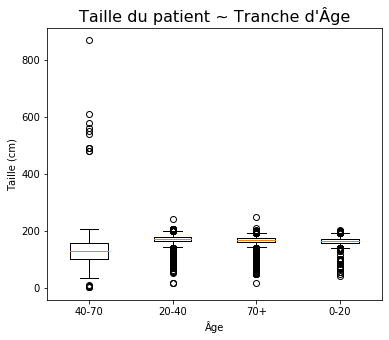

In [37]:
# Data used for the boxplpots
plt.figure(figsize=(6, 5))
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
labels={'0-20', '70+', '40-70', '20-40'}

# boxplot w/o ylim (outliers are visible)
plt.boxplot(data_bxplt, labels=labels)
plt.ylabel("Taille (cm)")
plt.xlabel("Âge")
plt.title("Taille du patient ~ Tranche d'Âge", fontsize=16)

On recommence en supprimant les valeurs de taille > 300 cm

Text(0.5, 1.0, 'Boxplot sans les outliers')

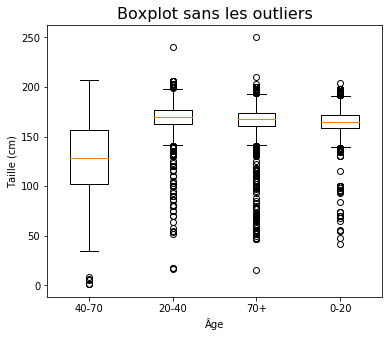

In [38]:
# boxplot w/o outliers
data20 = data20[data20["Taille"] < 300]
data_bxplt = [data20["Taille"], data20_40["Taille"], data40_70["Taille"], data70["Taille"]]
plt.figure(figsize=(6, 5))
plt.boxplot(data_bxplt, labels=labels)
plt.ylabel("Taille (cm)")
plt.xlabel("Âge")
plt.title("Boxplot sans les outliers", fontsize=16)

### Histogrammes : Taille du patient ~ Tranche d'Âge

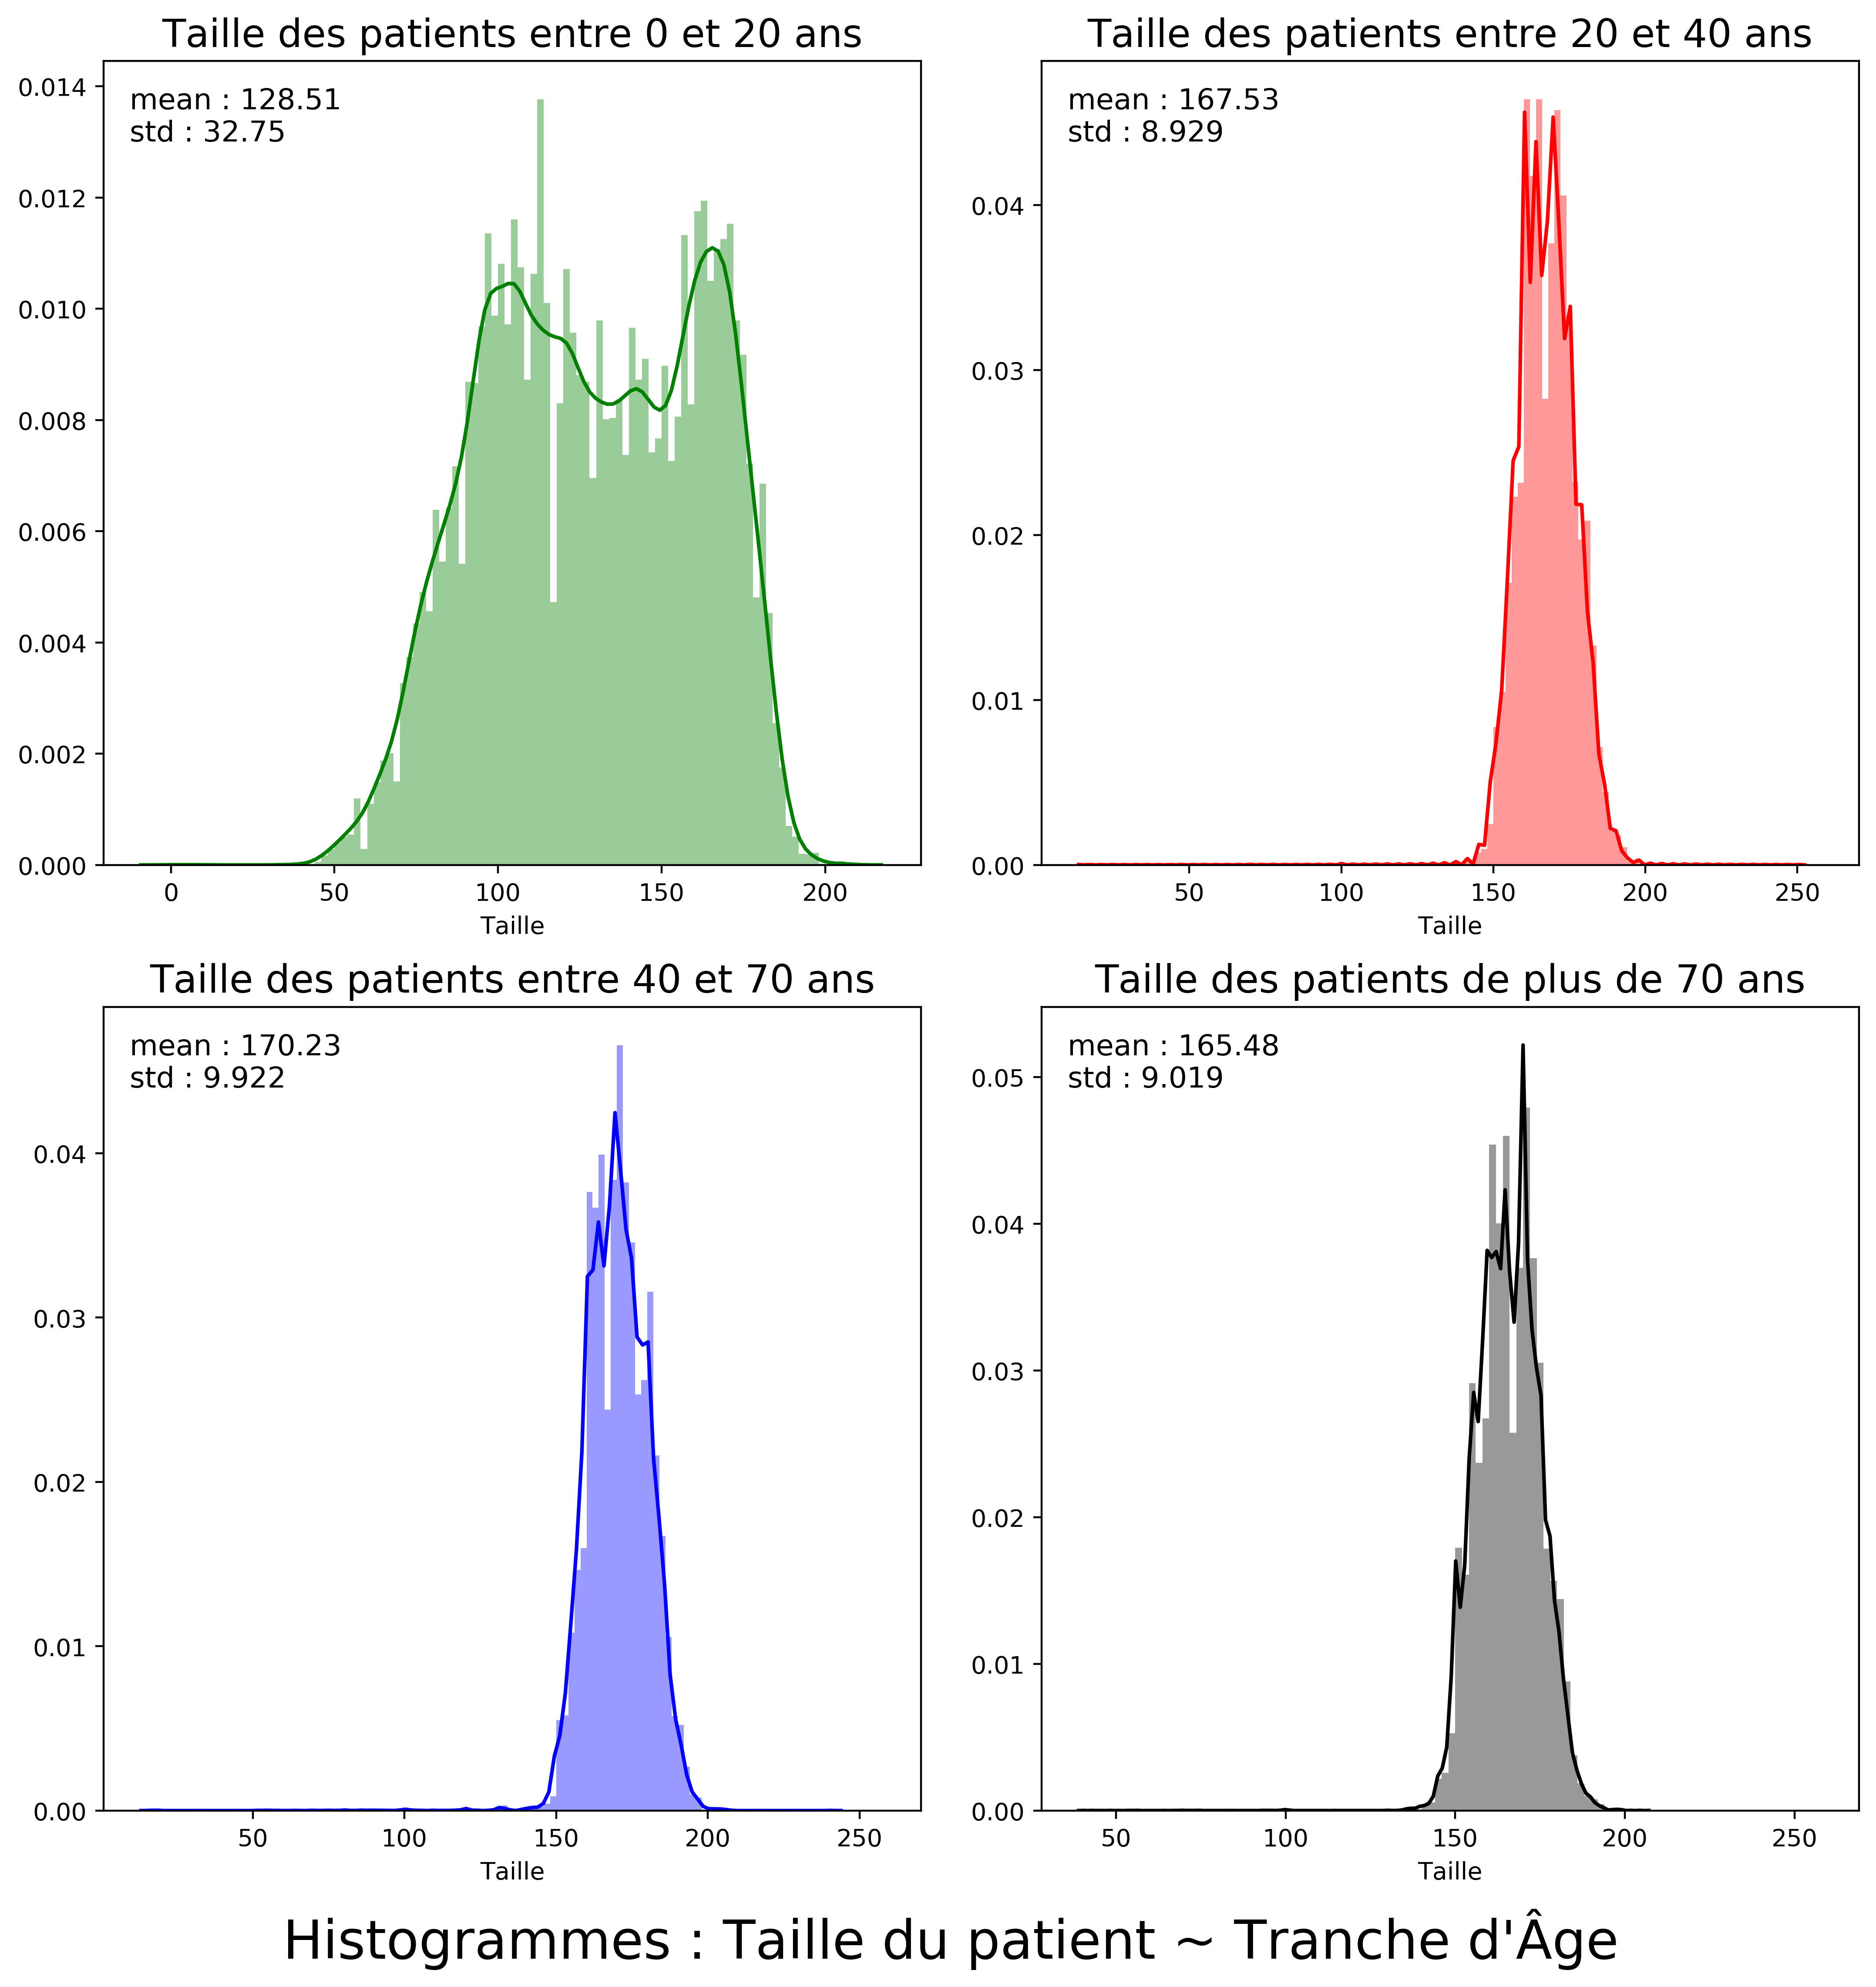

In [42]:
# plot a kernel density estimation over a stacked barchart
fig, axes = plt.subplots(2, 2, figsize=[11, 11], dpi=400)

# Labels def
lbl20 = "mean : " + str(round(groups_mean[0],2)) + "\nstd : " + str(round(groups_std[0],3))
lbl20_40 = "mean : " + str(round(groups_mean[1],2)) + "\nstd : " + str(round(groups_std[1],3))
lbl40_70 = "mean : " + str(round(groups_mean[2],2)) + "\nstd : " + str(round(groups_std[2],3))
lbl70 = "mean : " + str(round(groups_mean[3],2)) + "\nstd : " + str(round(groups_std[3],3))

# rugplot IQR
iqr20 = stats.mstats.mquantiles(data20['Taille'])
iqr20_40 = stats.mstats.mquantiles(data20_40['Taille'])
iqr40_70 = stats.mstats.mquantiles(data40_70['Taille'])
iqr70 = stats.mstats.mquantiles(data70['Taille'])

# Display mean, std
def mean_std_box(lbl, x, y):
    at = AnchoredText(lbl,
              prop=dict(size=12), frameon=False,
              loc='upper left',
              )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes[x][y].add_artist(at)


# //// [00-20] range histogram
sns.distplot(data20['Taille'], bins= np.arange(0,220,2),  color="g", ax=axes[0, 0],
            rug_kws = {'a' : iqr20, 'height' : 0.9, 'axis' : 'x', 'ax': axes[0][0]})
axes[0][0].set_title('Taille des patients entre 0 et 20 ans', fontsize=16)
mean_std_box(lbl20, 0, 0)

# //// [20-40] range histogram
sns.distplot(data20_40['Taille'], bins= np.arange(70,260,2), color="b", ax=axes[1, 0])
axes[0][1].set_title('Taille des patients entre 20 et 40 ans', fontsize=16)
mean_std_box(lbl20_40, 1, 0)

# //// [40-70] range histogram
sns.distplot(data40_70['Taille'], bins= np.arange(70,260,2), color="r", ax=axes[0, 1])
axes[1][0].set_title('Taille des patients entre 40 et 70 ans', fontsize=16)
mean_std_box(lbl40_70, 0, 1)

# //// [70-110] range histogram
sns.distplot(data70['Taille'], bins= np.arange(70,260,2), color="k", ax=axes[1, 1])
axes[1][1].set_title('Taille des patients de plus de 70 ans', fontsize=16)
mean_std_box(lbl70, 1, 1)

plt.suptitle("Histogrammes : Taille du patient ~ Tranche d'Âge", fontsize = 22, y = 0.)
plt.tight_layout(pad=1)

In [ ]:
stop = timeit.default_timer()
print()
print('Time:  ', str(round(stop - start, 4)), 's\n\t' + str(round((stop - start) / 60, 4)) + ' m ')
